In [2]:
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join, hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import ZScaleInterval

import numpy as np
from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
import astropy.cosmology
import matplotlib as mpl
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, LinearModel

# Enable inline plotting in this notebook
%matplotlib inline

pathtodata = '../data/'
pathtospectra = '/misc/marenostrum/pgperez/gbarro/DEIMOS/halo7d/data_reduction_HY_V2/'

import warnings
warnings.filterwarnings('ignore')

In [3]:
data=Table.read('../data/SIP_cos_spec_candels_data.hdf5')
data

HALO7D_ID,obs_date [15],obs_date.mask [15],mask_folder [15],mask_folder.mask [15],mask [15],mask.mask [15],slit [15],slit.mask [15],num_obs [1],num_obs.mask [1],zbest,zbest.mask,M_2a_tau,M_2a_tau.mask,M_14a_tau,M_14a_tau.mask,ir_SFRTOTf,ir_SFRTOTf.mask,WFC3_F160W_FLUX,WFC3_F160W_FLUX.mask
bytes13,bytes13,bool,bytes11,bool,bytes11,bool,int64,bool,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool
10046u,2016mar03 ..,False .. False,c3a ..,False .. False,c3a ..,False .. False,38 .. 0,False .. False,5,False,1.08,True,8.93,True,9.2966,True,0.116392,True,-99.0,True
10050,2015mar25 ..,False .. False,c0d ..,False .. False,c0d ..,False .. False,85 .. 0,False .. False,6,False,0.51,False,9.23,False,-99.0,False,1.72702,False,10.2653,False
10064,2015mar25 ..,False .. False,c0d ..,False .. False,c0d ..,False .. False,0 .. 0,False .. False,6,False,0.08,False,7.0,False,-99.0,False,0.0139669,False,3.11085,False
10075,2016dec27 ..,False .. False,c5a ..,False .. False,c5a ..,False .. False,58 .. 0,False .. False,2,False,1.08,True,8.93,True,9.2966,True,0.116392,True,-99.0,True
10105u,2016mar03 ..,False .. False,c3a ..,False .. False,c3a ..,False .. False,107 .. 0,False .. False,5,False,1.08,True,8.93,True,9.2966,True,0.116392,True,-99.0,True
10122,2016dec26 ..,False .. False,c1a ..,False .. False,c1a ..,False .. False,73 .. 0,False .. False,7,False,0.933,False,10.87,False,-99.0,False,22.4957,False,38.0882,False
10191,2016dec27 ..,False .. False,c4a ..,False .. False,c4a ..,False .. False,76 .. 0,False .. False,2,False,1.08,True,8.93,True,9.2966,True,0.116392,True,-99.0,True
10191u,2016mar03 ..,False .. False,c3a ..,False .. False,c3a ..,False .. False,104 .. 0,False .. False,5,False,0.402,False,8.72,False,8.8587,False,0.3665,False,2.33011,False
1022,2016dec26 ..,False .. False,c2a ..,False .. False,c2a ..,False .. False,49 .. 0,False .. False,7,False,0.67,False,11.04,False,-99.0,False,27.6563,False,53.1649,False


In [4]:
data['HALO7D_ID'] = data['HALO7D_ID'].astype(str)
data['obs_date'] = data['obs_date'].astype(str)
data['mask'] = data['mask'].astype(str)
data['mask_folder'] = data['mask_folder'].astype(str)
C = {'cos' : data}

In [5]:
def abmag(flux): 
    return -2.5*np.log10(flux)+23.9
def log10n(x):
    logx=np.choose(x>0.,(-99.,np.log10(x)))
    return logx

In [7]:
selection = (data['zbest'] > 0.6)\
& (data['zbest'] < 0.8)\
& (data['HALO7D_ID'] != '-999')\
& (data['M_2a_tau'] > 9)\
& (data['M_2a_tau'] < 10)\
& (log10n(data['ir_SFRTOTf'])>data['M_14a_tau']-9.5)\
& (data['M_14a_tau']>=9.5)\
& (abmag(data['WFC3_F160W_FLUX'])<24)

In [8]:
data["HALO7D_ID","zbest"][selection]

HALO7D_ID,zbest
str13,float64
10976,0.72
12002,0.72
13278,0.64
15647,0.77
20055,0.704
4811,0.623
6247,0.74
849,0.72


In [59]:
sp = np.flatnonzero(data['HALO7D_ID'] == '12002')[0] # Picking out the index of target galaxy in data table
print(data['obs_date'][sp]) # Show all observing runs for this object
print(data['mask'][sp]) # Show all corresponding masks for this object
run = 1 # Picking which of the runs to plot

['2016dec26' '2016dec26' '2017mar04' '2017mar04' '2017apr03' '' '' '' ''
 '' '' '' '' '' '']
['c2a' 'c2b' 'c2a' 'c2c' 'c2b' '' '' '' '' '' '' '' '' '' '']


In [60]:
hdu = fits.open(pathtospectra + data['obs_date'][sp][run] + '_red/' + data['mask_folder'][sp][run]\
               + '/spec1d.' + data['mask'][sp][run] + '.' + str('%03i'%data['slit'][sp][run]) + '.' +
               data['HALO7D_ID'][sp] + '.fits')
#/misc/marenostrum/pgperez/gbarro/DEIMOS/halo7d/data_reduction_HY_V2/2016mar03_red/c3a/spec1d.c3a.082.serendip2.fits',

Text(0, 0.5, 'Flux')

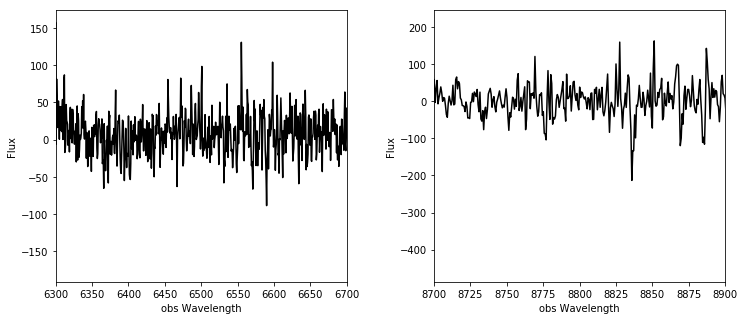

In [62]:
blue = hdu[1].data[0]
red = hdu[2].data[0]
f, ax = plt.subplots(1, 2, figsize = [12,5])
f.subplots_adjust(wspace = 0.3)

# Blue Side
ax[0].plot(blue['LAMBDA'], blue['SPEC'], 'k-')
# Around OII
ax[0].set_xlim(6300,6700)
ax[0].set_xlabel('obs Wavelength')
ax[0].set_ylabel('Flux')

# Red Side
ax[1].plot(red['LAMBDA'], red['SPEC'],'k-')
# Around OIII
ax[1].set_xlim(8700,8900)
ax[1].set_xlabel('obs Wavelength')
ax[1].set_ylabel('Flux')

In [54]:
def gaussian(x, amp, mu, sigma):
    return (amp / (sqrt(2*pi) * sigma)) * exp(-(x - mu)**2 / (2*sigma**2))

def index_of(arrval, value):
    if value < min(arrval):
        return 0 
    return max(np.where(arrval <= value)[0])

In [38]:
emline1 = GaussianModel()
bck1 = LinearModel()
emline2 = GaussianModel()
bck2 = LinearModel()
emline3 = GaussianModel()
bck3 = LinearModel()

In [39]:
linepars1 = bck1.make_params(intercept = blue['SPEC'].mean(), slope = 0)
linepars2 = bck2.make_params(intercept = red['SPEC'].mean(), slope = 0)
linepars3 = bck3.make_params(intercept = red['SPEC'].mean(), slope = 0)

lside1 = index_of(blue['LAMBDA'], 6450)
rside1 = index_of(blue['LAMBDA'], 6500)
linepars1 += emline1.guess(blue['SPEC'][lside1:rside1], x = blue['LAMBDA'][lside1:rside1])
lside2 = index_of(red['LAMBDA'], 8725)
rside2 = index_of(red['LAMBDA'], 8800)
linepars2 += emline2.guess(red['SPEC'][lside2:rside2], x = red['LAMBDA'][lside2:rside2])
lside3 = index_of(red['LAMBDA'], 8825)
rside3 = index_of(red['LAMBDA'], 8875)
linepars3 += emline3.guess(red['SPEC'][lside3:rside3], x = red['LAMBDA'][lside3:rside3])

In [40]:
linemodel1 = emline1 + bck1
fitline1 = linemodel1.fit(blue['SPEC'], linepars1, x = blue['LAMBDA'])
linemodel2 = emline2 + bck2
fitline2 = linemodel2.fit(red['SPEC'], linepars2, x = red['LAMBDA'])
linemodel3 = emline3 + bck3
fitline3 = linemodel3.fit(red['SPEC'], linepars3, x = red['LAMBDA'])

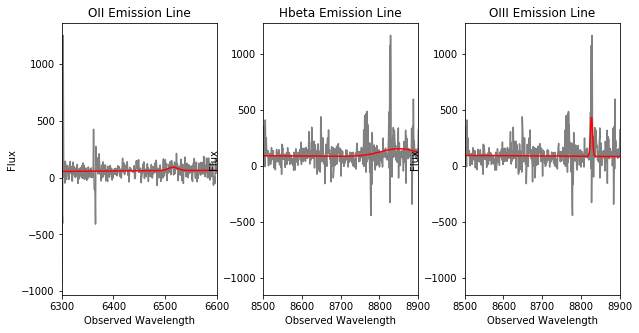

In [43]:
f,ax=plt.subplots(1,3,figsize=[10,5])
f.subplots_adjust(wspace=0.3)

#blue side
ax[0].plot(blue['LAMBDA'], blue['SPEC'], color = 'grey')
ax[0].plot(blue['LAMBDA'], fitline1.best_fit, 'r-')
ax[0].set_xlim(6300, 6600)
ax[0].set_xlabel('Observed Wavelength')
ax[0].set_ylabel('Flux')
ax[0].title.set_text('OII Emission Line')

#red side - Hbeta
ax[1].plot(red['LAMBDA'], red['SPEC'], color = 'grey')
ax[1].plot(red['LAMBDA'], fitline2.best_fit, 'r-')
ax[1].set_xlim(8500, 8900)
ax[1].set_xlabel('Observed Wavelength')
ax[1].set_ylabel('Flux')
ax[1].title.set_text('Hbeta Emission Line')

#red  side - OIII
ax[2].plot(red['LAMBDA'], red['SPEC'], color = 'grey')
ax[2].plot(red['LAMBDA'], fitline3.best_fit, 'r-')
ax[2].set_xlim(8500, 8900)
ax[2].set_xlabel('Observed Wavelength')
ax[2].set_ylabel('Flux')
ax[2].title.set_text('OIII Emission Line')

In [21]:
fitline1